In [1]:
import os

## switch to the root dir

In [2]:
os.chdir('..')
os.listdir()

['run',
 'srv',
 'opt',
 'sbin',
 'sys',
 'var',
 'usr',
 'dev',
 'lib',
 'boot',
 'bin',
 'proc',
 'mnt',
 'etc',
 'lib64',
 'home',
 'media',
 'tmp',
 'root',
 'content',
 '.dockerenv',
 'tools',
 'datalab',
 'tensorflow-1.15.2',
 'lib32',
 'python-apt']

In [3]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [4]:
os.chdir('/content/drive/MyDrive/Colab Notebooks/6321_project')
os.listdir()

['processed_data',
 'trainers',
 'models',
 'data_processor',
 'data_loader',
 'jupyter',
 'loggers',
 'saved_models']

In [5]:
from data_processor.utils import load_numpy_arrays, numpy_to_tensor
from models.MusicCNN2d import MusicCNN2d
from models.CNN_block import CNN_2d_block
from models.MLP import MLP
import trainers.SGD_trainer
from loggers.statistics_loggers import plot_numerical_arrays
import torch
from torch import nn

## Load preprocessed data

In [6]:
X_train, y_train, X_val, y_val = load_numpy_arrays(['data_train_X.npy','data_train_y.npy', 'data_val_X.npy','data_val_y.npy']
                  , path_prefix='processed_data/processed_waves/4-genres/')

In [7]:
X_train, y_train, X_val, y_val = numpy_to_tensor([X_train, y_train, X_val, y_val])

In [8]:
y_train = y_train.type(torch.int64)
y_val = y_val.type(torch.int64)

In [9]:
print(X_train.shape)
print(y_train.shape)

torch.Size([640, 501, 40])
torch.Size([640])


In [10]:
print(X_train[0])
print(y_train[0])

tensor([[-2.2604, -2.6280, -3.0352,  ..., -3.4321, -3.3666, -3.3074],
        [-2.5652, -3.0801, -3.3855,  ..., -2.7342, -2.6954, -2.6208],
        [-2.7137, -2.6825, -2.8931,  ..., -2.6997, -2.6482, -2.5789],
        ...,
        [-1.4595, -0.1884,  0.0382,  ..., -1.2723, -0.8131, -1.0031],
        [-1.1837, -0.1374,  0.1658,  ..., -1.1047, -0.7848, -0.9523],
        [-0.2428, -0.1665, -0.1290,  ..., -0.1786, -0.1607, -0.1630]])
tensor(1)


In [11]:
print(X_val.shape)
print(y_val.shape)

torch.Size([80, 501, 40])
torch.Size([80])


## Load model

1. define model under the folder models
2. import and define the model

In [12]:
class MusicCNN2d_attempt2(nn.Module):

    def __init__(self):
        super(MusicCNN2d, self).__init__()
        self.conv1 = CNN_2d_block(
            in_channels=1,
            out_channels=8,
            kernel_size=3,
            stride=2,
            padding=1,
            pooling_kernel_size=2,
            pooling_stride=2,
            pooling_padding=0,
            pooling='max',
            activation='ReLU',
            batch_norm=True
        )

        self.conv2 = CNN_2d_block(
            in_channels=8,
            out_channels=32,
            kernel_size=3,
            stride=2,
            padding=1,
            pooling_kernel_size=2,
            pooling_stride=2,
            pooling_padding=0,
            pooling='max',
            activation='ReLU',
            batch_norm=True
        )
        self.MLP = MLP(10000, 4, [1000, 50])
        # self.linear3 = nn.Linear(50, 4)

    def forward(self, x):
        out = self.conv1(x)
        # print(out.shape)
        out = torch.flatten(out, 1)
        out = self.MLP(out)
        return out

In [13]:
model = MusicCNN2d()

In [14]:
n_feat = X_train.shape[2]
n_time = X_train.shape[1]

In [15]:
X_a = X_train[:10].reshape((-1, 1, n_time, n_feat))
print(X_a.shape)
pred = model(X_a)
print(pred.shape)

torch.Size([10, 1, 501, 40])
torch.Size([10, 4])


## Define loss and optimizer

In [16]:
lr = 0.01
batch_size = 40
num_epoch = 50
model_name = 'CNN2d'
saved_model_name = 'saved_models/saved_' + model_name + '_wave.pt'

In [17]:
loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

## Train

use trainers.SGD_trainer.train or define a trainer

parameters of SGD_trainer.train
- model
- train_array: a tuple (X_train, y_train, X_val, y_val)
- loss
- optimizer
- batch_size
- num_epoch
- device

In [18]:
X_train_2d = X_train.reshape((-1, 1, n_time, n_feat))
#print(X_train.shape)
X_val_2d = X_val.reshape((-1, 1, n_time, n_feat))
training_loss_array, training_accuracy_array, validation_loss_array, validation_accuracy_array = trainers.SGD_trainer.train(model, (X_train_2d, y_train, X_val_2d, y_val), 
                  loss, optimizer, batch_size = batch_size, num_epoch = num_epoch, device='cuda')

Epoch  0: loss on final training batch: 1.4464
training accuracy: 31.41% validation accuracy: 41.25%
Epoch  1: loss on final training batch: 1.3915
training accuracy: 33.28% validation accuracy: 41.25%
Epoch  2: loss on final training batch: 1.3158
training accuracy: 40.16% validation accuracy: 33.75%
Epoch  3: loss on final training batch: 1.2674
training accuracy: 44.84% validation accuracy: 40.00%
Epoch  4: loss on final training batch: 1.2223
training accuracy: 50.63% validation accuracy: 48.75%
Epoch  5: loss on final training batch: 1.2251
training accuracy: 50.78% validation accuracy: 46.25%
Epoch  6: loss on final training batch: 1.1613
training accuracy: 56.09% validation accuracy: 55.00%
Epoch  7: loss on final training batch: 1.1817
training accuracy: 53.91% validation accuracy: 48.75%
Epoch  8: loss on final training batch: 1.1595
training accuracy: 56.09% validation accuracy: 51.25%
Epoch  9: loss on final training batch: 1.1236
training accuracy: 57.34% validation accurac

## Plot

plot_numerical_arrays: plot multiple arrays with the same length

parameters:
- num_arrays: numerical arrays with the same length
- labels: labels of each array(with the same order of num_arrays)
- xlabel
- ylabel
- title

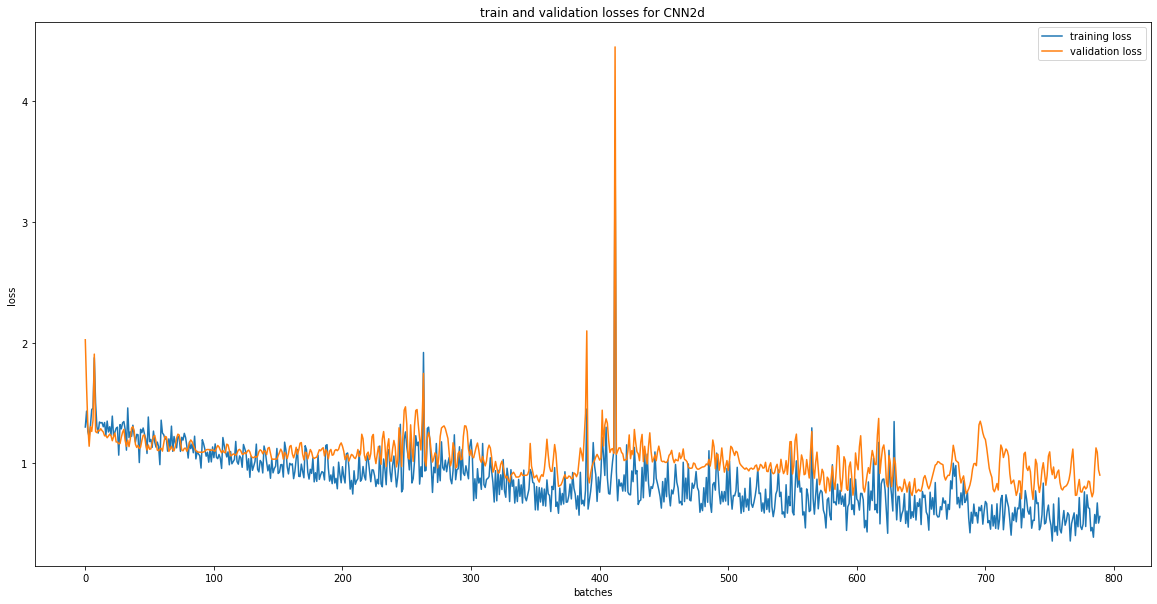

In [19]:
plot_numerical_arrays([training_loss_array[10:], validation_loss_array[10:]], ['training loss', 'validation loss'], 
                      xlabel='batches', ylabel='loss', title='train and validation losses for ' + model_name)

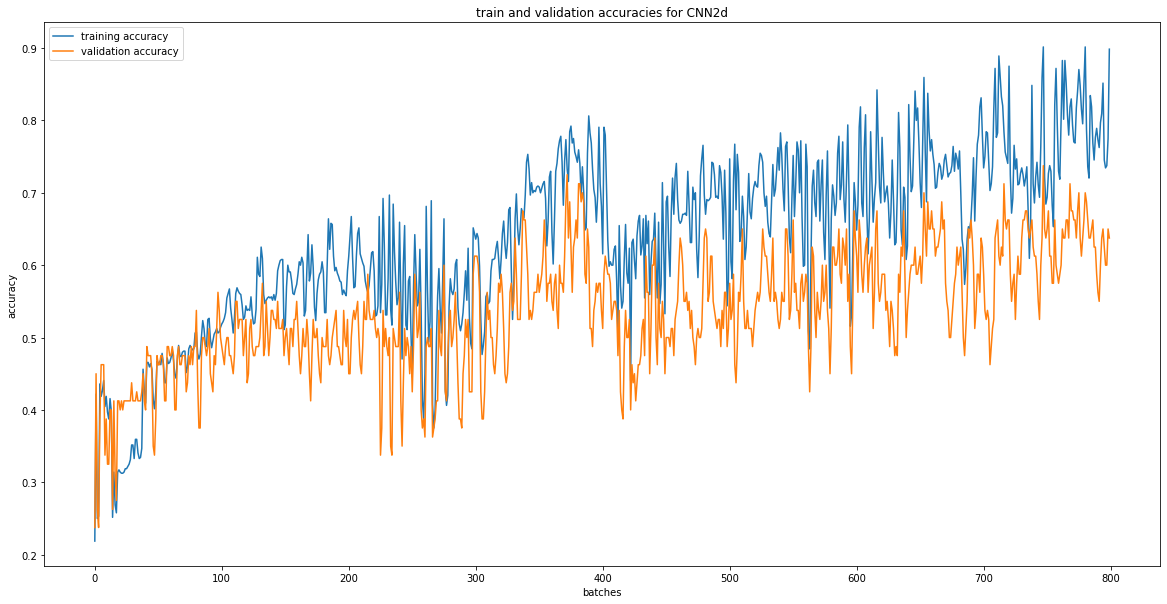

In [20]:
plot_numerical_arrays([training_accuracy_array, validation_accuracy_array], ['training accuracy', 'validation accuracy'], 
                      xlabel='batches', ylabel='accuracy', title='train and validation accuracies for ' + model_name)

## Save model

Save model in 'saved_models/saved_modelname_wave.pt'

In [21]:
torch.save(model.state_dict(), saved_model_name)

## Test

In [29]:
from loggers.trainer_loggers import cal_accuracy

In [40]:
X_test, y_test = load_numpy_arrays(['data_test_X.npy','data_test_y.npy']
                  , path_prefix='processed_data/processed_waves/4-genres/')
X_test, y_test = numpy_to_tensor([X_test, y_test])
X_test_2d = X_test.reshape((-1, 1, n_time, n_feat))

In [42]:
print('testing accuracy: %.2f%%' % (cal_accuracy(model, X_test_2d, y_test) * 100))

testing accuracy: 63.75%
